# Train a logistic regression on 7 species!

Sunday, May 20, 2018

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
import os
import sys

#Store the relative and absolute path to the home directory of the project
project_directory = '../..'
project_path = os.path.abspath(os.path.join(project_directory))

#Add the project path to the system path if necessesary, to be able to load modules from subdirectories
if project_path not in sys.path:
    sys.path.append(project_path)

In [4]:
import src.image_manager as im
import src.model_eval as meval

## Load the feature data frames and append them together

In [5]:
acer_picea_platanus_path = os.path.join(project_path, 'data', 'features_3species_20180514.csv')
alnus_thuja_path = os.path.join(project_path, 'data', 'features_alnus_thuja.csv')
features_cedrus_pseudotsuga_path = os.path.join(project_path, 'data', 'features_cedrus_pseudotsuga.csv')

In [7]:
acer_picea_platanus_df = im.load_df(acer_picea_platanus_path)
alnus_thuja_df = im.load_df(alnus_thuja_path)
cedrus_pseudotsuga_df = im.load_df(features_cedrus_pseudotsuga_path)

In [8]:
features_df = acer_picea_platanus_df.append(alnus_thuja_df).append(cedrus_pseudotsuga_df)
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3556
Columns: 2051 entries, p_hash to incv3_out_2047
dtypes: float64(2048), object(3)
memory usage: 61.6+ MB


In [9]:
features_df.head()

,p_hash,filename,folder,incv3_out_0,incv3_out_1,incv3_out_2,incv3_out_3,incv3_out_4,incv3_out_5,incv3_out_6,...,incv3_out_2038,incv3_out_2039,incv3_out_2040,incv3_out_2041,incv3_out_2042,incv3_out_2043,incv3_out_2044,incv3_out_2045,incv3_out_2046,incv3_out_2047
0,9bb759cb29b01a25,image_bigleaf_maple_57.png,acer_macrophyllum,0.180042,0.057599,0.632024,0.021612,0.297033,0.011966,0.903157,...,0.360490,0.009282,0.055258,0.110056,0.058888,0.201237,0.198077,1.394304,0.155102,0.000000
1,99c20b3b74d53de0,image_bigleaf_maple_43.png,acer_macrophyllum,0.667066,0.249269,0.074132,0.177577,0.520580,0.167225,0.233005,...,1.446164,0.920353,0.823285,0.617185,0.121126,0.065866,0.876259,0.226926,0.274808,0.000000
2,a1e1e0d4e646e765,image_big_leaf_maple_bark_48.png,acer_macrophyllum,0.159188,0.011783,0.187351,0.211521,0.466182,0.387081,0.217815,...,1.198391,0.460702,0.157247,0.267633,0.006349,0.466702,0.641492,1.066418,0.145887,0.223863
3,abee94c19cb28b0e,image_acer_macrophylum_tree_49.png,acer_macrophyllum,0.658278,0.010192,0.344359,0.192652,0.342696,0.362848,0.562928,...,0.257585,0.077631,0.057183,0.411228,0.417154,0.048589,0.421282,0.057896,0.325496,0.145896
4,d3c161631f2b4b4e,image_bigleaf_maple_94.png,acer_macrophyllum,0.056695,0.255299,0.407071,0.066481,0.000076,0.568202,0.362414,...,1.289151,0.578341,0.963826,0.028785,0.310883,0.001386,1.154405,0.034431,0.768076,0.217323


In [10]:
features_df.tail()

,p_hash,filename,folder,incv3_out_0,incv3_out_1,incv3_out_2,incv3_out_3,incv3_out_4,incv3_out_5,incv3_out_6,...,incv3_out_2038,incv3_out_2039,incv3_out_2040,incv3_out_2041,incv3_out_2042,incv3_out_2043,incv3_out_2044,incv3_out_2045,incv3_out_2046,incv3_out_2047
3552,f28e1ca12dc9956b,image_pseudotsuga_menziesii_tree_77.png,pseudotsuga_menziesii,0.094600,0.061064,0.438699,0.062858,0.182481,0.185814,0.167514,...,0.178922,0.057688,0.062832,1.061262,0.107008,0.072353,0.160739,0.071515,0.237690,0.342455
3553,b64af14559635e52,image_douglas_fir_needles_75.png,pseudotsuga_menziesii,0.414487,0.138089,0.428809,0.093233,0.279266,0.325341,0.363008,...,0.777865,0.040818,0.263513,0.201849,0.734593,0.856769,1.216158,0.154447,0.888354,0.514273
3554,bc2d91738a768b62,image_pseudotsuga_menziesii_tree_63.png,pseudotsuga_menziesii,0.141211,0.025822,0.279416,0.242231,0.240942,0.029662,0.001973,...,0.051108,0.095992,0.701401,0.898264,0.051929,0.375273,0.293792,0.064906,0.078290,0.308257
3555,d414e491bc7e0b4f,image_douglas_fir_needles_61.png,pseudotsuga_menziesii,0.924379,0.032280,0.729098,0.103906,0.834279,0.702138,0.192425,...,0.513257,0.053753,0.019497,0.148256,0.009697,0.741581,0.619497,0.536302,0.356287,0.106888
3556,ab2aa82adfa954a5,image_douglas_fir_needles_49.png,pseudotsuga_menziesii,0.439043,0.136890,0.371879,0.072276,0.090010,0.177785,0.196581,...,0.952160,0.090075,0.051675,0.002637,0.025259,0.620770,0.016263,0.042990,0.006773,0.591485


In [11]:
features_df['folder'].value_counts()

cedrus_libani            650
thuja_plicata            575
picea_sitchensis         572
alnus_rubra              567
platanus_acerifolia      541
acer_macrophyllum        526
pseudotsuga_menziesii    502
Name: folder, dtype: int64

## Pull out features (X) and labels (y), and get a train-test split¶

In [12]:
non_feature_cols = ['p_hash', 'filename', 'folder']
X = features_df.drop(non_feature_cols, axis=1)
y = features_df['folder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=876)

In [13]:
print(f'Train: {len(X_train)}, Test: {len(X_test)}')

Train: 3146, Test: 787


In [14]:
y_train.value_counts()

cedrus_libani            515
picea_sitchensis         467
thuja_plicata            456
alnus_rubra              449
platanus_acerifolia      445
acer_macrophyllum        413
pseudotsuga_menziesii    401
Name: folder, dtype: int64

In [15]:
y_test.value_counts()

cedrus_libani            135
thuja_plicata            119
alnus_rubra              118
acer_macrophyllum        113
picea_sitchensis         105
pseudotsuga_menziesii    101
platanus_acerifolia       96
Name: folder, dtype: int64

In [ ]:
[x/7 for x in range(7)]

In [16]:
np.log(7) #Baseline for log loss

1.9459101490553132

## Try Ridge Logistic Regression with best C from 4 species model

In [18]:
log_model = LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='sag', C=0.1, max_iter=4000, verbose=1)

In [19]:
log_model.fit(X_train, y_train)

convergence after 229 epochs took 38 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.7s finished


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=4000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=1,
          warm_start=False)

In [20]:
logeval = meval.ModelEvaluator(log_model)
logeval.print_classifier_metrics(X_train, X_test, y_train, y_test)

Train log_loss: 0.3173700267721209, Test log_loss: 1.002594676140932
Train accuracy: 0.9551811824539097, Test accuracy: 0.6442185514612452


In [21]:
logeval.confusion_df(X_test, y_test)

,Predicted acer_macrophyllum,Predicted alnus_rubra,Predicted cedrus_libani,Predicted picea_sitchensis,Predicted platanus_acerifolia,Predicted pseudotsuga_menziesii,Predicted thuja_plicata
Actual acer_macrophyllum,69,9,9,1,14,5,6
Actual alnus_rubra,10,75,5,7,13,4,4
Actual cedrus_libani,6,5,84,13,2,15,10
Actual picea_sitchensis,5,4,3,69,1,15,8
Actual platanus_acerifolia,15,3,0,3,74,1,0
Actual pseudotsuga_menziesii,1,6,19,14,2,51,8
Actual thuja_plicata,4,8,10,7,0,5,85


## Do a grid search to find the best C

My guess is that the best C will be greater than or equal to the best for 4 species (0.1), i.e. less regularization since we have more data. In particular, we now have more data points than features for the first time.

In [22]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
gridsearch = GridSearchCV(estimator=log_model,
                          param_grid=param_grid, 
                          scoring=['neg_log_loss', 'accuracy'],
                          refit='neg_log_loss')

In [23]:
gridsearch.fit(X_train, y_train)

convergence after 192 epochs took 21 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.8s finished


convergence after 204 epochs took 22 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s finished


convergence after 193 epochs took 21 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.0s finished


convergence after 216 epochs took 24 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s finished


convergence after 272 epochs took 29 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.5s finished


convergence after 308 epochs took 33 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.8s finished


convergence after 344 epochs took 38 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.1s finished


convergence after 360 epochs took 41 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.7s finished


convergence after 368 epochs took 40 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.0s finished


convergence after 736 epochs took 81 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


convergence after 784 epochs took 83 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


convergence after 761 epochs took 80 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


convergence after 220 epochs took 35 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=4000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=1,
          warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit='neg_log_loss', return_train_score='warn',
       scoring=['neg_log_loss', 'accuracy'], verbose=0)

In [26]:
gridsearch.best_params_

{'C': 0.1}

Hmm, so it looks like the best C it found is the one we already tried.

In [24]:
pd.DataFrame(gridsearch.cv_results_)

/Users/ndbs/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ndbs/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_neg_log_loss'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ndbs/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ndbs/anaconda3/lib

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_neg_log_loss,mean_train_accuracy,mean_train_neg_log_loss,param_C,params,rank_test_accuracy,rank_test_neg_log_loss,...,split2_test_accuracy,split2_test_neg_log_loss,split2_train_accuracy,split2_train_neg_log_loss,std_fit_time,std_score_time,std_test_accuracy,std_test_neg_log_loss,std_train_accuracy,std_train_neg_log_loss
0,21.315029,0.010657,0.617610,-1.088621,0.802453,-0.780084,0.01,{'C': 0.01},2,2,...,0.616268,-1.109190,0.796287,-0.774249,0.483910,0.000280,0.009531,0.019449,0.004366,0.004823
1,28.626767,0.010863,0.630960,-1.050520,0.973457,-0.292520,0.1,{'C': 0.1},1,1,...,0.630622,-1.073086,0.975250,-0.289098,3.869403,0.000019,0.009093,0.015988,0.001284,0.002718
2,39.623432,0.012973,0.612524,-1.366869,1.000000,-0.060548,1,{'C': 1},3,3,...,0.613397,-1.386545,1.000000,-0.059747,1.080634,0.001524,0.003703,0.016094,0.000000,0.000682
3,81.566244,0.011317,0.603942,-1.857869,1.000000,-0.011375,10,{'C': 10},4,4,...,0.606699,-1.878987,1.000000,-0.010976,1.615501,0.000891,0.002862,0.019327,0.000000,0.000283


In [27]:
#This should give the same results as before
log_model = gridsearch.best_estimator_
logeval = meval.ModelEvaluator(log_model)
logeval.print_classifier_metrics(X_train, X_test, y_train, y_test)
logeval.confusion_df(X_test, y_test)

Train log_loss: 0.3173700267721209, Test log_loss: 1.002594676140932
Train accuracy: 0.9551811824539097, Test accuracy: 0.6442185514612452


,Predicted acer_macrophyllum,Predicted alnus_rubra,Predicted cedrus_libani,Predicted picea_sitchensis,Predicted platanus_acerifolia,Predicted pseudotsuga_menziesii,Predicted thuja_plicata
Actual acer_macrophyllum,69,9,9,1,14,5,6
Actual alnus_rubra,10,75,5,7,13,4,4
Actual cedrus_libani,6,5,84,13,2,15,10
Actual picea_sitchensis,5,4,3,69,1,15,8
Actual platanus_acerifolia,15,3,0,3,74,1,0
Actual pseudotsuga_menziesii,1,6,19,14,2,51,8
Actual thuja_plicata,4,8,10,7,0,5,85


## Let's search a few more C values near 0.1

Note that in the gridsearch, the next best value was 0.01, so the best C might be somewhere in between.

In [29]:
10**(1/3)

2.154434690031884

In [35]:
[2.154434690031884**p for p in range(4)]

[1.0, 2.154434690031884, 4.641588833612779, 10.000000000000002]

In [36]:
param_grid = {'C': [0.0215, 0.0464, 0.1, 0.215]}
gridsearch = GridSearchCV(estimator=log_model,
                          param_grid=param_grid, 
                          scoring=['neg_log_loss', 'accuracy'],
                          return_train_score=True,
                          refit='neg_log_loss')

In [37]:
gridsearch.fit(X_train, y_train)

convergence after 235 epochs took 25 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.6s finished


convergence after 234 epochs took 25 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s finished


convergence after 247 epochs took 27 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.1s finished


convergence after 261 epochs took 27 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.4s finished


convergence after 289 epochs took 31 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.6s finished


convergence after 284 epochs took 31 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.3s finished


convergence after 223 epochs took 24 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.4s finished


convergence after 272 epochs took 29 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.5s finished


convergence after 297 epochs took 32 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.0s finished


convergence after 155 epochs took 16 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s finished


convergence after 162 epochs took 18 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s finished


convergence after 170 epochs took 19 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.1s finished


convergence after 237 epochs took 40 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=4000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=1,
          warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.0215, 0.0464, 0.1, 0.215]},
       pre_dispatch='2*n_jobs', refit='neg_log_loss',
       return_train_score=True, scoring=['neg_log_loss', 'accuracy'],
       verbose=0)

In [38]:
gridsearch.best_params_

{'C': 0.0464}

In [40]:
gridsearch.best_estimator_

LogisticRegression(C=0.0464, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=4000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=1,
          warm_start=False)

In [39]:
pd.DataFrame(gridsearch.cv_results_)

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_neg_log_loss,mean_train_accuracy,mean_train_neg_log_loss,param_C,params,rank_test_accuracy,rank_test_neg_log_loss,...,split2_test_accuracy,split2_test_neg_log_loss,split2_train_accuracy,split2_train_neg_log_loss,std_fit_time,std_score_time,std_test_accuracy,std_test_neg_log_loss,std_train_accuracy,std_train_neg_log_loss
0,25.582637,0.011259,0.628417,-1.036844,0.866178,-0.603519,0.0215,{'C': 0.0215},3,2,...,0.623923,-1.058245,0.867206,-0.598349,1.090620,0.000532,0.007112,0.018323,0.000949,0.003666
1,29.487124,0.013618,0.634456,-1.022300,0.926570,-0.436708,0.0464,{'C': 0.0464},1,1,...,0.629665,-1.044183,0.930509,-0.432232,1.442935,0.002363,0.003971,0.016588,0.003627,0.003304
2,28.345892,0.010665,0.630960,-1.050527,0.973457,-0.292520,0.1,{'C': 0.1},2,3,...,0.630622,-1.073082,0.975250,-0.289099,3.128261,0.000135,0.009093,0.015981,0.001284,0.002718
3,17.803324,0.011616,0.620153,-1.121781,0.995549,-0.182153,0.215,{'C': 0.215},4,4,...,0.619139,-1.144191,0.996668,-0.179918,1.016856,0.000751,0.010674,0.015957,0.000983,0.001873


In [124]:
#This should give different results, hopefully better...
log_model = gridsearch.best_estimator_
logeval = meval.ModelEvaluator(log_model)
logeval.print_classifier_metrics(X_train, X_test, y_train, y_test)
logeval.confusion_df(X_test, y_test)

Train log_loss: 0.45402520125432755, Test log_loss: 0.974286534493626
Train Matthews CC: 0.8905793051708235, Test Matthews CC: 0.592198036059199
Train accuracy: 0.9062301335028607, Test accuracy: 0.650571791613723
Train top_2_accuracy: 0.9713922441195169, Test top_2_accuracy: 0.8360864040660737
Train top_3_accuracy: 0.9914176732358551, Test top_3_accuracy: 0.9059720457433291


,Predicted acer_macrophyllum,Predicted alnus_rubra,Predicted cedrus_libani,Predicted picea_sitchensis,Predicted platanus_acerifolia,Predicted pseudotsuga_menziesii,Predicted thuja_plicata
Actual acer_macrophyllum,70,8,6,1,17,5,6
Actual alnus_rubra,11,74,5,8,13,4,3
Actual cedrus_libani,5,5,86,13,2,16,8
Actual picea_sitchensis,6,5,3,66,1,16,8
Actual platanus_acerifolia,10,4,0,2,79,1,0
Actual pseudotsuga_menziesii,2,7,18,13,2,51,8
Actual thuja_plicata,6,6,10,7,0,4,86


## Figure out how to compute top-k accuracy

In [53]:
y_pred = log_model.predict_proba(X_test)
y_pred[:5]

array([[  9.43973975e-02,   9.56008178e-02,   7.48665682e-02,
          6.77461076e-02,   2.58129496e-01,   5.04825178e-03,
          4.04211361e-01],
       [  1.07374138e-01,   7.67111941e-02,   1.60458881e-01,
          1.96749587e-02,   1.35313216e-03,   8.39505323e-02,
          5.50477164e-01],
       [  1.34566960e-01,   4.90236729e-03,   5.71736970e-03,
          1.76230958e-03,   3.33526196e-03,   8.31814150e-02,
          7.66534317e-01],
       [  3.80195524e-02,   2.70769303e-04,   4.03901521e-03,
          3.64901283e-04,   6.56323286e-05,   2.59502658e-03,
          9.54645103e-01],
       [  8.13707688e-02,   2.70758772e-02,   3.35666865e-02,
          6.52965174e-03,   8.08568494e-01,   1.83507752e-02,
          2.45377463e-02]])

In [54]:
y_pred.shape

(787, 7)

In [69]:
np.argsort(y_pred, axis=1)#[:,:]

array([[5, 3, 2, ..., 1, 4, 6],
       [4, 3, 1, ..., 0, 2, 6],
       [3, 4, 1, ..., 5, 0, 6],
       ..., 
       [2, 3, 5, ..., 1, 0, 4],
       [4, 0, 1, ..., 3, 5, 2],
       [1, 3, 5, ..., 0, 6, 4]])

In [82]:
np.argsort(y_pred, axis=1)[:5,-3:]

array([[1, 4, 6],
       [0, 2, 6],
       [5, 0, 6],
       [2, 0, 6],
       [2, 0, 4]])

In [81]:
log_model.classes_[np.argsort(y_pred, axis=1)[:5,-3:]]

array([['alnus_rubra', 'platanus_acerifolia', 'thuja_plicata'],
       ['acer_macrophyllum', 'cedrus_libani', 'thuja_plicata'],
       ['pseudotsuga_menziesii', 'acer_macrophyllum', 'thuja_plicata'],
       ['cedrus_libani', 'acer_macrophyllum', 'thuja_plicata'],
       ['cedrus_libani', 'acer_macrophyllum', 'platanus_acerifolia']], dtype=object)

In [76]:
y_test[:5]

521       acer_macrophyllum
3718       picea_sitchensis
3877       picea_sitchensis
1767          thuja_plicata
5036    platanus_acerifolia
Name: folder, dtype: object

In [101]:
np.array([y_test.iloc[i] in log_model.classes_[np.argsort(y_pred, axis=1)[i,-3:]] for i in range(len(y_test))]).mean()
#Top 2: 0.83608640406607371
#Top 3: 0.90597204574332912

0.90597204574332912

In [122]:
#This is now ported into model_eval.py
def top_k_accuracy(y_true, y_pred, classes, k=3):
    ranked_predictions = classes[np.argsort(y_pred, axis=1)[:,-k:]]
    #print(ranked_predictions)
    return np.array([y_true.iloc[i] in ranked_predictions[i] for i in range(len(y_true))]).mean()

In [115]:
top_k_accuracy(y_test, y_pred, log_model.classes_, k=2)

[['platanus_acerifolia' 'thuja_plicata']
 ['cedrus_libani' 'thuja_plicata']
 ['acer_macrophyllum' 'thuja_plicata']
 ..., 
 ['acer_macrophyllum' 'platanus_acerifolia']
 ['pseudotsuga_menziesii' 'cedrus_libani']
 ['thuja_plicata' 'platanus_acerifolia']]


0.83608640406607371

In [123]:
top_k_accuracy(y_test, y_pred, log_model.classes_, k=1)

0.65057179161372303

In [125]:
[top_k_accuracy(y_test, y_pred, log_model.classes_, k) for k in range(1,8)]

[0.65057179161372303,
 0.83608640406607371,
 0.90597204574332912,
 0.95298602287166456,
 0.97585768742058454,
 0.99237611181702667,
 1.0]

## Let's get a list of ranked predictions for each test image

In [148]:
y_test[:10]

521       acer_macrophyllum
3718       picea_sitchensis
3877       picea_sitchensis
1767          thuja_plicata
5036    platanus_acerifolia
5010    platanus_acerifolia
4969    platanus_acerifolia
2777          cedrus_libani
2786          cedrus_libani
1325          thuja_plicata
Name: folder, dtype: object

In [149]:
meval.top_k_predictions(y_test, y_pred, log_model.classes_, k=7)[:10]

array([['thuja_plicata', 'platanus_acerifolia', 'alnus_rubra',
        'acer_macrophyllum', 'cedrus_libani', 'picea_sitchensis',
        'pseudotsuga_menziesii'],
       ['thuja_plicata', 'cedrus_libani', 'acer_macrophyllum',
        'pseudotsuga_menziesii', 'alnus_rubra', 'picea_sitchensis',
        'platanus_acerifolia'],
       ['thuja_plicata', 'acer_macrophyllum', 'pseudotsuga_menziesii',
        'cedrus_libani', 'alnus_rubra', 'platanus_acerifolia',
        'picea_sitchensis'],
       ['thuja_plicata', 'acer_macrophyllum', 'cedrus_libani',
        'pseudotsuga_menziesii', 'picea_sitchensis', 'alnus_rubra',
        'platanus_acerifolia'],
       ['platanus_acerifolia', 'acer_macrophyllum', 'cedrus_libani',
        'alnus_rubra', 'thuja_plicata', 'pseudotsuga_menziesii',
        'picea_sitchensis'],
       ['platanus_acerifolia', 'alnus_rubra', 'picea_sitchensis',
        'cedrus_libani', 'pseudotsuga_menziesii', 'thuja_plicata',
        'acer_macrophyllum'],
       ['platanus_acer

In [150]:
y_train[:10]

2519        cedrus_libani
5308          alnus_rubra
2844        cedrus_libani
5265          alnus_rubra
5124          alnus_rubra
2488        cedrus_libani
373     acer_macrophyllum
4002     picea_sitchensis
1527        thuja_plicata
1412        thuja_plicata
Name: folder, dtype: object

## Let's try making a nice confusion matrix

Monday, May 21, 2018

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
species = ['Maple', 'Alder', 'Cedar', 'Spruce', 'Plane', 'Doug-fir', 'Red-cedar']

In [130]:
confusion_df = logeval.confusion_df(X_test, y_test)

Confusion matrix, without normalization
[[70  8  6  1 17  5  6]
 [11 74  5  8 13  4  3]
 [ 5  5 86 13  2 16  8]
 [ 6  5  3 66  1 16  8]
 [10  4  0  2 79  1  0]
 [ 2  7 18 13  2 51  8]
 [ 6  6 10  7  0  4 86]]


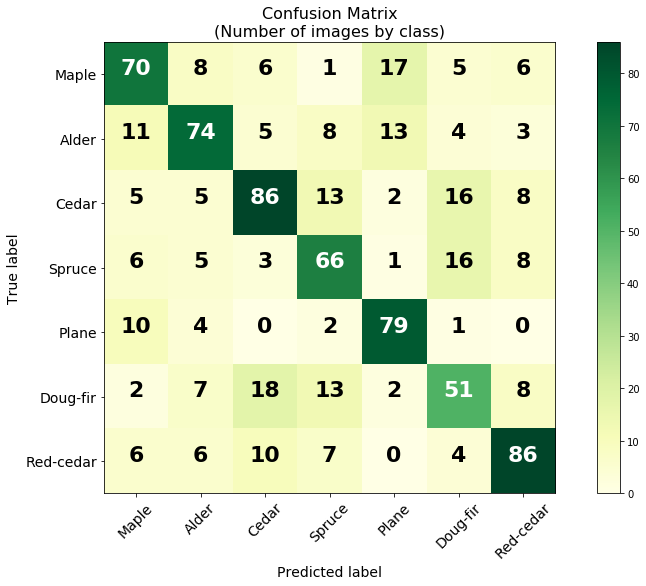

In [156]:
plt.figure(figsize=(12,8))
meval.plot_confusion_matrix(confusion_df.values, species, cmap='YlGn', colorbar=True)
plt.savefig(project_path + '/data/confusion_7species.png',bbox_inches="tight")
plt.show()

In [ ]:
plt.yticks(tick_marks, classes)